# Rainbow Trout Genome Exploration
This study demonstrates a new method for determining the sex of rainbow trout using genetic information and machine learning.

## Importing necessary packages

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

%autosave 30

Autosaving every 30 seconds


In [72]:
SEED = 32 # Random State

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

## Data
The information regarding the data in the paper mentions that the first column is the target column, indication of the gender of the rainbow trout fish.
* Male : 0
* Female : 1

The remaining columns are the SNPs of the rainbow trout. There is a _unified error rate (in %)_ across all SNPs, indicated by the number at the end of the data file's name. A _unified error rate_ across all SNPs means that the same percentage of genotyping errors was applied to every single nucleotide polymorphism (SNP) marker in the dataset.

For the Sim_5 dataset, a 5% unified error rate was used. This means that for each of the 15 SNP markers:
* 5% of the non-missing genotypes were randomly selected to deviate from the ground truth model.
* The same 5% error rate was applied consistently across all 15 SNPs.

Additionally, a few samples with missing SNP information were selected randomly. The missing SNP genotypes were coded as 5.

In [2]:
print("Available Data:")
os.listdir("./data")

Available Data:


['sim_random.dat', 'sim_5.dat', 'sim_real.dat', 'sim_50.dat']

In [3]:
# List of column names
# GN: Gender, M{i}: Marker{i} for i:(1,15)
columnName = ['GN'] + [f'M{i}' for i in range(1,16)]

In [4]:
dataPath = "./data/sim_real.dat"
dataPath = "./data/sim_5.dat"

data = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
data.replace(5, np.nan, inplace=True)
print(f"Shape of data: {data.shape}")
data.head()

Shape of data: (14010, 16)


,GN,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15
0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0
1,0,1.0,NaN,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
2,1,NaN,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,2.0


The data in the markers is represented as follows:
* Heterozygous genotype: Coded as 1
* Homozygous genotype: Coded as 2
* Missing data: Initially coded as 5, then converted to ‘not-a-number’ (nan) during analysis

In genetics, heterozygous and homozygous refer to the genetic composition of an organism for a particular trait or gene.
* An organism is heterozygous when it carries two different alleles (versions) of a gene. Male rainbow trout were assumed to be heterozygous
* An organism is homozygous when it carries two identical alleles of a gene. Female rainbow trout were assumed to be homozygous

In [5]:
print(f"Number of rows with a missing SNP in their sequence: {data[data.isna().any(axis=1)].shape[0]} ")
print(f"Total numer of sequences: {data.shape[0]}\n")
print(f"Ratio to missing sequences: {data[data.isna().any(axis=1)].shape[0]*100/data.shape[0]} %")

Number of rows with a missing SNP in their sequence: 7520 
Total numer of sequences: 14010

Ratio to missing sequences: 53.675945753033545 %


More that 50% of the data samples have atleast one missing SNP.

## Exploring Data

In [43]:
# Distribution of the gender class
data['GN'].replace({1:'Female',0:'Male'}).value_counts(normalize=True)*100

GN
Female    60.0
Male      40.0
Name: proportion, dtype: float64

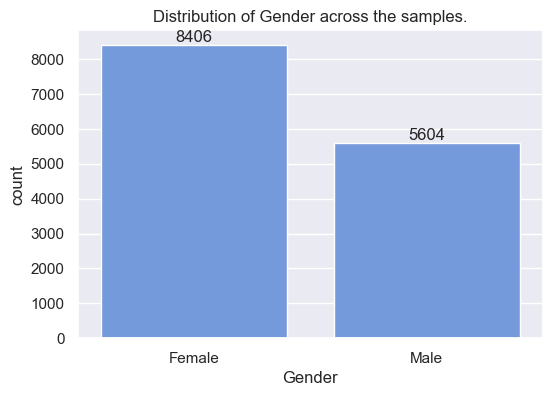

In [6]:
color = 'cornflowerblue'
plt.figure(figsize = (6,4), dpi = 100)
ax = sns.barplot(data=data['GN'].replace({1:'Female',0:'Male'}).value_counts(), color=color)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Distribution of Gender across the samples.")
plt.xlabel("Gender")
plt.show()

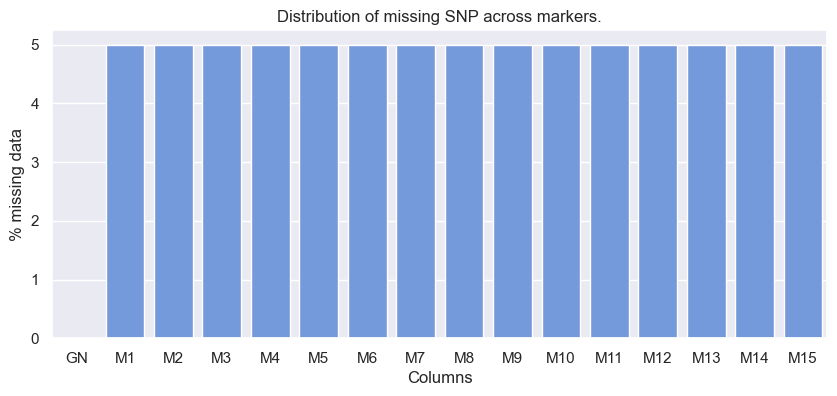

In [7]:
fnx = lambda col : col[col.isna()].shape[0]*100/col.shape[0]
plt.figure(figsize = (10,4), dpi = 100)
sns.barplot(data=data.apply(fnx), color=color)
plt.title("Distribution of missing SNP across markers.")
plt.xlabel("Columns")
plt.ylabel("% missing data")
plt.show()

This indicates that about 700 samples per marker was missing among all the samples. This was cross validated with the paper too.

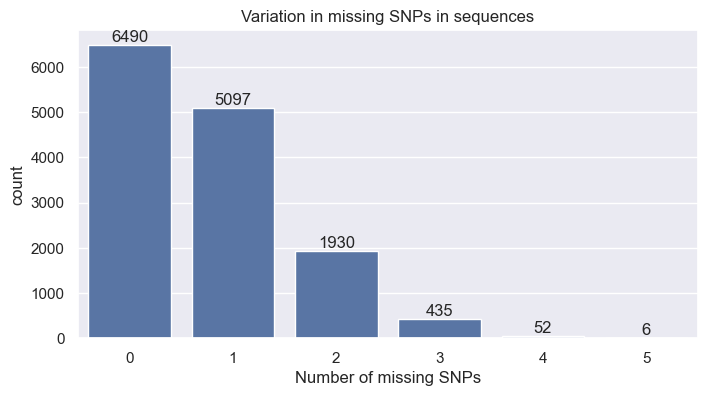

In [8]:
missData = data.isna().sum(axis=1)

plt.figure(figsize = (8,4), dpi = 100)
ax = sns.barplot(data=missData.value_counts(normalize=False), color = color)
for i in ax.containers:
    ax.bar_label(i,)

plt.title("Variation in missing SNPs in sequences")
plt.xlabel("Number of missing SNPs")
plt.show()

In [9]:
%%time
fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataCount = data.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataCount.columns = ['HETEROZ','HOMOZ','MISS']
dataCount = dataCount.assign(GENDER = data['GN'])
dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
dataCount.head()

CPU times: user 1.9 s, sys: 19.9 ms, total: 1.92 s
Wall time: 1.5 s


,HETEROZ,HOMOZ,MISS,GENDER
0,2.0,13.0,0.0,FEMALE
1,12.0,1.0,2.0,MALE
2,1.0,13.0,1.0,FEMALE
3,0.0,14.0,1.0,FEMALE
4,1.0,13.0,1.0,FEMALE


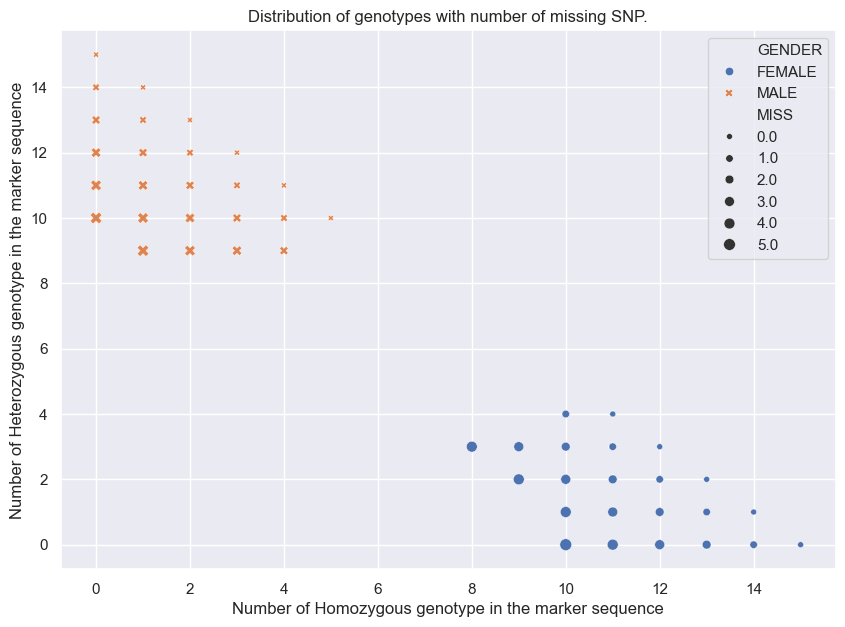

In [11]:
plt.figure(figsize = (10,7), dpi = 100)
sns.scatterplot(data=dataCount, x='HOMOZ', y='HETEROZ', size='MISS', style='GENDER', hue ='GENDER')
plt.title("Distribution of genotypes with number of missing SNP.")
plt.xlabel("Number of Homozygous genotype in the marker sequence")
plt.ylabel("Number of Heterozygous genotype in the marker sequence")
plt.show()

### Auxiliary Functions

In [67]:
def resultAnalysisFnx(ytrue,ypred,target_names=['MALE','FEMALE']):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names))
    else:
        print(classification_report(ytrue,ypred))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(6, 4))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names)
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True)

## Hypothesis 1
As a general trend, we can comment that, the more heterozygous genotypes the sequence has, the higher chance for the fish to be a male. A simple model can be built on top of this comment.

Potential Algorithms:
* Logistic Regression (for classification tasks)
* Support Vector Machines

In [25]:
%%time
dataPath = "./data/sim_5.dat"

data = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
data.replace(5, np.nan, inplace=True)

CPU times: user 16 ms, sys: 3.17 ms, total: 19.2 ms
Wall time: 19.5 ms


In [26]:
%%time
fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataCount = data.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataCount.columns = ['HETEROZ','HOMOZ','MISS']
dataCount = dataCount.assign(GENDER = data['GN'])
# dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
dataCount.head()

CPU times: user 1.6 s, sys: 46.6 ms, total: 1.65 s
Wall time: 1.62 s


,HETEROZ,HOMOZ,MISS,GENDER
0,2.0,13.0,0.0,1
1,12.0,1.0,2.0,0
2,1.0,13.0,1.0,1
3,0.0,14.0,1.0,1
4,1.0,13.0,1.0,1


### Logistic Regression

In [40]:
# Importing the package for Logistic Regression
from sklearn.linear_model import LogisticRegression

In [35]:
inpData, tarData = dataCount.iloc[:,:-1], dataCount.iloc[:,-1]

print("Shapes of input & target data:")
print(inpData.shape, tarData.shape)

Shapes of input & target data:
(14010, 3) (14010,)


In [38]:
# Since we do not have anamolies in the data, we can Normalization over Standardization.
scaler = MinMaxScaler()

inpData_sca = scaler.fit_transform(inpData)

In [45]:
inpData_sca.shape

(14010, 3)

In [49]:
# Splitting the data into training (70%) and testing data (30%)
xtrain, xtest, ytrain, ytest = train_test_split(inpData_sca, tarData, test_size=0.3, stratify=tarData)

print(f"Size of training data: {xtrain.shape} \nSize of testing data: {xtest.shape}")

Size of training data: (9807, 3) 
Size of testing data: (4203, 3)


In [51]:
%%time
# Since the gender/target class is not heavily imbalanced, we can attempt NOT having class weights for now.
logRes_clf = LogisticRegression(random_state=SEED)

logRes_clf.fit(xtrain, ytrain)

CPU times: user 141 ms, sys: 4.03 ms, total: 145 ms
Wall time: 34.6 ms


LogisticRegression(random_state=32)

In [55]:
%%time
ypred = logRes_clf.predict(xtest)

CPU times: user 105 ms, sys: 3.39 ms, total: 108 ms
Wall time: 23.1 ms


              precision    recall  f1-score   support

        MALE       1.00      1.00      1.00      1681
      FEMALE       1.00      1.00      1.00      2522

    accuracy                           1.00      4203
   macro avg       1.00      1.00      1.00      4203
weighted avg       1.00      1.00      1.00      4203



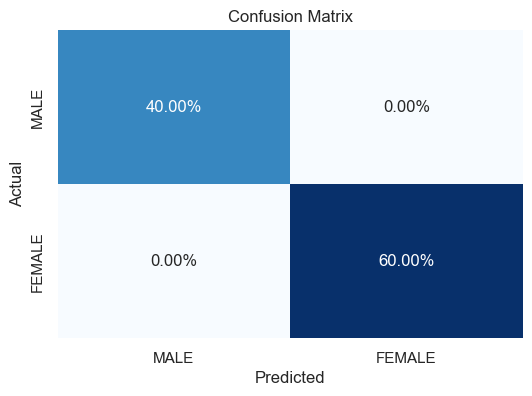

In [63]:
report = resultAnalysisFnx(ytest, ypred, ['MALE','FEMALE'])

#### Testing on different datasets

In [73]:
%%time
dataPath = "./data/sim_real.dat"

dataV2 = pd.read_csv(dataPath, header = None, sep=',', names=columnName)
# Replacing 5 with np.NaN
dataV2.replace(5, np.nan, inplace=True)

fnx = lambda row: row.value_counts(normalize=False,dropna=False)
dataV2Count = dataV2.iloc[:,1:].apply(fnx,axis=1).fillna(0)
dataV2Count.columns = ['HETEROZ','HOMOZ','MISS']
dataV2Count = dataV2Count.assign(GENDER = dataV2['GN'])
# dataCount['GENDER'] = dataCount['GENDER'].replace({0:'MALE',1:'FEMALE'})
# dataV2Count.head()

inpDataV2, tarDataV2 = dataV2Count.iloc[:,:-1], dataV2Count.iloc[:,-1]

inpDataV2_sca = scaler.transform(inpDataV2)

CPU times: user 1.68 s, sys: 61.1 ms, total: 1.74 s
Wall time: 1.71 s


              precision    recall  f1-score   support

        MALE       0.98      0.98      0.98      5604
      FEMALE       0.98      0.99      0.99      8406

    accuracy                           0.98     14010
   macro avg       0.98      0.98      0.98     14010
weighted avg       0.98      0.98      0.98     14010



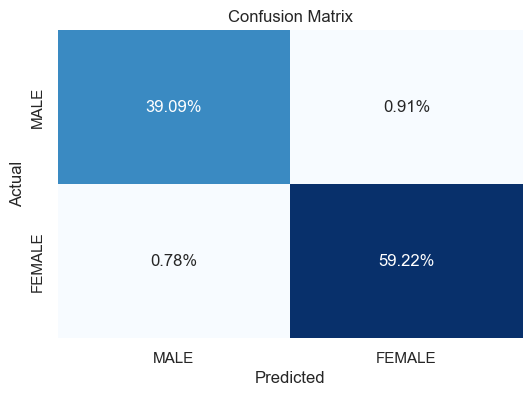

CPU times: user 279 ms, sys: 727 ms, total: 1.01 s
Wall time: 133 ms


In [74]:
%%time
ypredV2 = logRes_clf.predict(inpDataV2_sca)
report = resultAnalysisFnx(tarDataV2, ypredV2)

## Hypothesis 2
Look into the sequnce of genotypes to comment on the gender.

**work in progress**